# Bike Price Prediction

## 1. Problem Formulation


The goal of the project is to create a  deep-learning model to predict the offer-price in Euros of a bicycle given an image of the same bycicle. 
The idea for this problem is inspired by the [CS229 2018 Stanford course](https://www.example.com), where one of the instructors proposes a similar semester project. 
<br>
The web is scraped for images of bicycles and their corresponding prices. 

2. Initially, the data is to be explored to show potential areas of improvement. Some problems for preprocessing might include: 
- Filtering out non-bicycle images
- bicycles with non-monotonous background and bicycles not facing sideways
- data bias (source, color, resolution, orientation)
- incorrect pricing

3. A baseline model using the Residual Neural Network architecture is built
- only basic preprocessing steps are applied to the training data
- the loss function and metrics are defined 
- the model is trained and progress visualized
- the trained model's layer activations and the prediction heatmap is visualized

4. The baseline model is improved 
- data augmentation is applied
- hyperparamter tuning (using bayesian optimization) is applied
- the activations and the heatmap is visualized 

## 2. Preliminaries

#### Neural Networks

#### Convolutional Neural Networks
Convolutional Neural Networks (CNNS) were first proposed by  LeCun et al. in 1998. 
The domain they are mostly used in is computer vision, extracting knowledge from images.

CNNS implement an operation called the convolution, where a filter "slides" or convolves across the input to compute a feature map. This operation is implemented in two dimensions as shown in equation $(1)$, where $Y[i,j]$ is the feature map at position $(i,j)$, $X$ the input and $H$ the filter with dimensions $K \times K$. 

$$
\begin{equation}
Y[i, j] = \sum_{m=0}^{K-1} \sum_{n=0}^{K-1} X[i+m, j+n] \cdot H[m, n]  \quad \text(1)
\end{equation}
$$

The dimensions of $Y$ are determined by the formula $(2)$ for each of the $n$ dimensions. The $Stride$ determines which "step-size" the convolution operation uses. $Padding$ may be concatenated around the input, for example zero-padding. The formula can be rewritten to find the ideal stride, padding or kernel size, to keep or reduce the feature dimensions from $X$ to $Y$ using the convolution operation.    



$$
\begin{equation}
\text{Output Size} = \left(\frac{\text{Input Size} - \text{Kernel Size} + 2 \times \text{Padding}}{\text{Stride}}\right) + 1 \quad \text(2)
\end{equation}
$$

Another operation in the CNN is the pooling operation. Essentially, it is a convolution operation, were the mean or the maximum in the filter window is extracted. 


Making use of the convolution operations, data with low signal-to-noise ratio, like images, can be reduced to essential features. The sliding window approach enabels parameter-sharing for each of the inputs and thereby also reduce computational cost. This is effective because in images local features often can also be found globally. CNNs can be used for arbitrarily n-dimensional data, examples include one-dimensional signal processing or cancer detection from a three-dimensional scan, where the filter is n-dimensional respectively.

Filters are initialized randomly and improved using backpropagation.

CNNs can use multiple per layer...


@article{LeCun1998GradientbasedLA,
  title={Gradient-based learning applied to document recognition},
  author={Yann LeCun and L{\'e}on Bottou and Yoshua Bengio and Patrick Haffner},
  journal={Proc. IEEE},
  year={1998},
  volume={86},
  pages={2278-2324}
}

Alakwaa, Wafaa, Mohammad Nassef, and Amr Badr. "Lung cancer detection and classification with 3D convolutional neural network (3D-CNN)." International Journal of Advanced Computer Science and Applications 8.8 (2017).



In [1]:
## He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).

In [2]:
# Imports and Global Variables
import os
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm
from google.colab import drive
drive.mount('/content/drive')
DRIVE_FOLDER = Path('/content/drive/MyDrive/DataExplorationProject/')
SEED = 4 # random seed
np.random.seed(SEED)

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from sklearn.metrics.pairwise import cosine_similarity



Mounted at /content/drive


## 3. Data exploration, overview, cleaning

### 3.1 Webscraping and cleaning considerations
50000 images from the web are accumulated. 

#### Scraping
1. High quality images come from the websites "fahrrad.de" (1500 images) and "www.fahrrad-xxl.de" (5500 images). 
2. The remaining ~7000 images are scraped from the "shopping" tab of "www.google.com". After trial and error, following methods are recognized to work well using the keywords "bicycle","citybike", "ebike", "mountainbike", "racingbike", "childrens bike", "trekkingbike", "holland bicycle", "bmx" and their german equivalents. These keywords cover the common types.

   2.1. First method: Scraping is executed using breathfirst search, starting with the above-mentioned initial keywords. The links of the (n+1)-depth are found  by the "further recommendations" in each (n)-depth search. Already downloaded images are tracked in a csv file. It is found that a depth of  n=2 is sufficient, the amount of new images in depth n>2 is sparse.
   
   2.2. Second method: Above-mentioned keywords are combined with the words of bicycle colors (['blue','brown','yellow','orange','turkis','purple','white', 'grey', 'green','red','silver']) and also price ranges (200 till 1500 in "50" steps, 1500 till 3000 in "500" steps, 3000 till 6000 in "3000" steps) to scrape further images.  
3. In both cases, also the subsequent pages of each search result are crawled. The technologies used for web-crawling are [Scrapy](https://scrapy.org/) (for 1.), a efficient scraping library, and  [microsoft-playwright](https://playwright.dev/) (for 2.), which is similar to [Selenium](https://www.selenium.dev/) a browser-based test-automation tool, but may be utilized for scraping. Playwright allows for better page accessibility than Scrapy. 

#### Considerations for subsequent exploration and cleaning
1. Especially the data scraped from google.com includes images of other objects or multiple bicycles. The inclusion of images of bicycles with non-monotonous or with non-sideview depiction may increase the difficulty for an algorithm to depict features of a bike, and therefore 50000 images may not be sufficient.
1. The scraped bicycle images and their prices are likely to include regional bias (Germany), as well as incorrect, only regional pricing. Also, the prices are dependent on the date extracted (June 2023). As mentioned in the problem formulation, assigned prices are solely "offer"-prices and may not reflect the prices for which they are sold. 

Option: Precompute image Embeddings of the frozen layers of the CNN. This saves computational cost and time

--- exploratory data analysis ideas: compute "average image", see eigenfaces or fisher faces https://en.wikipedia.org/wiki/Eigenface or simply compute mean image, compute this per price range, plot image dimensions on x, y axis. Plot these or also plot colors per price range to see if there are any color biases. 

use weights and biases to track data

### 3.2 Data Exploration and cleaning

In [3]:
unzipped = False

In [4]:
if not unzipped:
  !unzip /content/drive/MyDrive/DataExplorationProject/bicycles_xxl.zip
  !unzip /content/drive/MyDrive/DataExplorationProject/bicycles_de.zip
  !unzip /content/drive/MyDrive/DataExplorationProject/bicycles_goog.zip
  unzipped =True

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: content/bicycles_all/640adc6f-d52b-3d0a-8664-55f7384c6969_1599.00.jpg  
  inflating: content/bicycles_all/0d5dae00-08c7-3347-87c3-ac45ad426b94_205.87.jpg  
  inflating: content/bicycles_all/0b11fbe7-7fd1-3177-a761-45ec673de440_736.49.jpg  
  inflating: content/bicycles_all/e4258919-1b2a-39f0-a4a8-054942570cb0_444.00.jpg  
  inflating: content/bicycles_all/8f976931-bd44-3bad-b494-6154f91ab677_2799.00.jpg  
  inflating: content/bicycles_all/germany_004ed149-5218-4bb4-80f7-a9bba61037f10_3899.00.jpg  
  inflating: content/bicycles_all/f3eb4d06-a7a5-3682-acba-ebb04514d658_525.00.jpg  
  inflating: content/bicycles_all/ce0c325d-203b-3bf8-b51f-097d71ea10ef_6029.50.jpg  
  inflating: content/bicycles_all/germany_9248014e-b490-4e68-b170-e85fb98869770_1199.00.jpg  
  inflating: content/bicycles_all/a08f2f6d-23e6-305f-ad8a-ca46d3ca8edd_367.67.jpg  
  inflating: content/bicycles_all/germany_84427a65-a02d-45c7-98b0-04a7

#### 2.2.1 Removing duplicate images
The webscraping process does not ensure that only unique images are loaded.
1. Compute image embeddings with a standard 50 resnet-blocks deep resnet which was pretrained on the ImageNet dataset. Only the base model without the prediction head is used. "model.summary()" below shows the architecture of the model. The output of the last average-pooling layer is used for the embeddings thus each image is represented by a 2048-dimensional vector.

2. filter images: label few "bad" examples by hand, and use their embeddings to localize similar images
3. verify visually



In [21]:
# Load  pretrained ResNet50 model, was pretrained on 1000 class imagenet
base_model = ResNet50(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)
model_clf_head = Model(inputs=base_model.get_layer('avg_pool').output, outputs=base_model.get_layer('predictions').output)

In [6]:
# we take last layers output, model is without classification head
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [7]:
# 1. Compute embeddings


# preprocess imgs
def preprocess_image(img_path):
  img = image.load_img(img_path, target_size=(224, 224))
  img_data = image.img_to_array(img)
  img_data = np.expand_dims(img_data, axis=0)
  img_data = preprocess_input(img_data)
  return img_data

# compute embeddings
def compute_embeddings(folder_path, batch_size=64):
  dataset_name = folder_path.split('/')[-1]
  p = DRIVE_FOLDER/(dataset_name+'_resnet50embeddings.npz')
  
  if os.path.exists(p): # load embeddings instead of computing, if already recomputed
    print(f"load already precomputed embeddings in file {p}")
    return np.load(p)

  image_list = os.listdir(folder_path)
  num_images = len(image_list)
  num_batches = int(np.ceil(num_images / batch_size))

  image_embeddings = {}

  for i in tqdm(range(num_batches),total=num_batches):
    batch_images = []
    start = i * batch_size
    end = min((i + 1) * batch_size, num_images)

    for j in range(start, end):
      try:
        img_path = os.path.join(folder_path, image_list[j])
        img_data = preprocess_image(img_path)
      except BaseException as e:
        print(e, image_list[j])
      batch_images.append(img_data)
    
    batch_data = np.vstack(batch_images)
    batch_embeddings = model.predict(batch_data)

    for j in range(batch_embeddings.shape[0]):
      image_embeddings[os.path.join(folder_path, image_list[start + j])] = batch_embeddings[j]

  return image_embeddings

# Compute embeddings for images in all folders
embeddings_goog = compute_embeddings('/content/bicycles_goog')
embeddings_de = compute_embeddings('/content/bicycles_de')
embeddings_xxl = compute_embeddings('/content/bicycles_xxl')

load already precomputed embeddings in file /content/drive/MyDrive/DataExplorationProject/bicycles_goog_resnet50embeddings.npz
load already precomputed embeddings in file /content/drive/MyDrive/DataExplorationProject/bicycles_de_resnet50embeddings.npz
load already precomputed embeddings in file /content/drive/MyDrive/DataExplorationProject/bicycles_xxl_resnet50embeddings.npz


In [8]:
embeddings = {}
for _dict, source in zip([embeddings_goog, embeddings_de, embeddings_xxl],['goog','de','xxl']):
  for key in _dict:
    embeddings[Path(key).name] = {'embedding':_dict[key], 'source':source}

In [9]:
# 2.0 get handlabeled images
!unzip /content/drive/MyDrive/DataExplorationProject/'image_classes.zip'

Archive:  /content/drive/MyDrive/DataExplorationProject/image_classes.zip
   creating: content/image_classes/
   creating: content/image_classes/x_only_chassy/
  inflating: content/image_classes/x_only_chassy/4b6921ea-822a-3628-8c02-80b48598ed80_392.43.jpg  
  inflating: content/image_classes/x_only_chassy/9fa49abd-6580-3f5c-a8ff-aeb1bd744611_600.62.jpg  
  inflating: content/image_classes/x_only_chassy/4a89bc4d-bcd2-352b-b0ec-c293fd056307_569.00.jpg  
  inflating: content/image_classes/x_only_chassy/9d032ed3-8275-3b15-8559-ae9525920b3d_524.44.jpg  
  inflating: content/image_classes/x_only_chassy/0e999b9e-3fed-31ed-897e-887abae37249_640.00.jpg  
  inflating: content/image_classes/x_only_chassy/db157d46-181c-36ae-8e39-4ea4136f8e58_582.79.jpg  
  inflating: content/image_classes/x_only_chassy/0a04c31e-044e-3bf1-a948-1351cc42c0a2_923.40.jpg  
  inflating: content/image_classes/x_only_chassy/dbae9a1b-e702-31e9-87c7-3f5ac577313b_482.88.jpg  
  inflating: content/image_classes/x_only_chassy

In [10]:
!ls /content/content/image_classes

bike_not_fromside_or_only_part	    childrensbike  mountainbike  x_only_chassy
bike_with_nonmonotonous_background  citybike	   racing_bike	 xonlywheels
bmx				    ebike	   xnobike


In [11]:
from matplotlib.layout_engine import TightLayoutEngine
# code adapted from https://stackoverflow.com/a/72804014
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.image as mpimg

def plot_image_urls(img_urls, col_count=10, img_text=None):
  images = [
      mpimg.imread(url) for url in img_urls
  ]
  row_count = int(len(img_urls)/col_count) + 1

  fig = plt.figure(figsize=(8., 18.))
  grid = ImageGrid(fig, 111, nrows_ncols=(row_count, col_count), axes_pad=0.1)

  if img_text is None:
    img_text = ['' for _ in range(len(img_urls))]
  for ax, im, txt in zip(grid, images, img_text):
      ax.imshow(im)
      ax.set_title(txt, fontdict=None, loc='center', color = "k")
   
  plt.show()

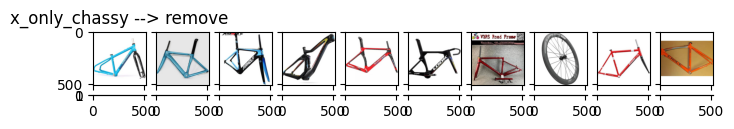

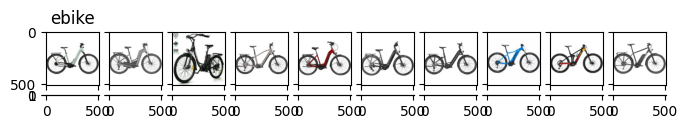

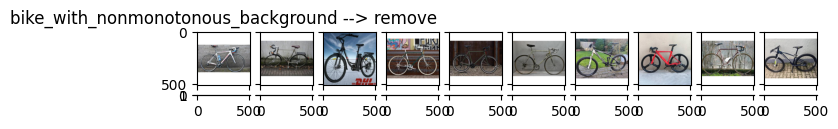

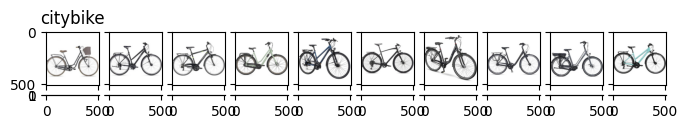

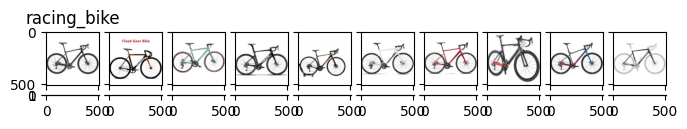

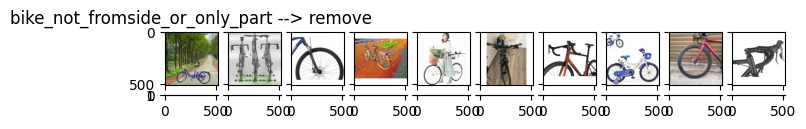

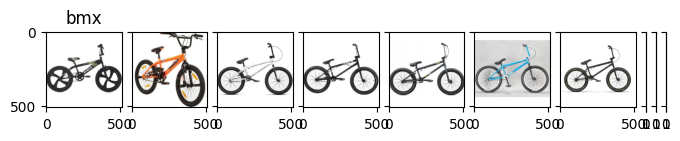

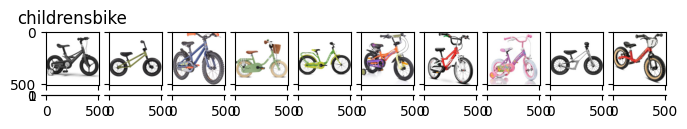

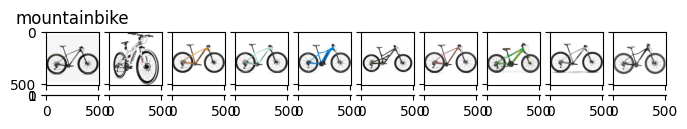

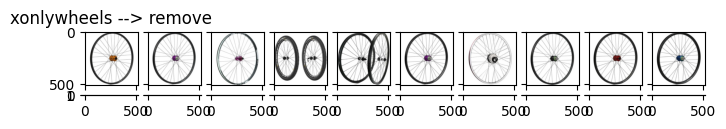

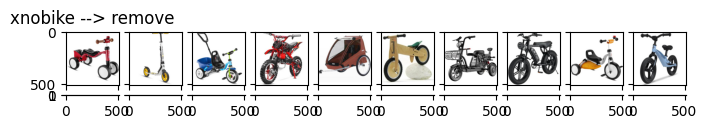

In [12]:
folder = Path('/content/content/image_classes')

potential_remove_categories = ['bike_not_fromside_or_only_part', 'bike_with_nonmonotonous_background','x_only_chassy', 'xonlywheels', 'xnobike']
image_classes = {category:{'remove':category in potential_remove_categories, 'images': [folder/category/img for img in os.listdir(folder/category) ]} for category in os.listdir(folder) }

for category, category_data in image_classes.items():
  take = 10
  images = category_data['images'][:take]

  titles = [category+' --> remove' if category_data['remove'] and i==0 else category if i==0 else '' for i in range(len(images))]
  plot_image_urls(images, img_text=titles, col_count = take)


In [13]:
# add embedding_center to classes
for c in image_classes:
  class_embeddings = []
  for img_path in image_classes[c]['images']:
    key = Path(img_path).name
    if key in embeddings:
      class_embeddings.append(embeddings[key]['embedding'])

  class_embeddings = np.array(class_embeddings)
  mean_embedding = np.mean(class_embeddings, axis = 0)
  image_classes[c]['embeddings'] = class_embeddings
  image_classes[c]['mean_embedding'] = mean_embedding
  print(f'{len(class_embeddings)} images of class {c}, mean: {mean_embedding}')

13 images of class x_only_chassy, mean: [0.20105672 0.23551229 0.04932462 ... 0.3578033  0.41676897 0.1221743 ]
34 images of class ebike, mean: [0.29853302 0.20309539 0.04881984 ... 0.48783582 0.02638867 0.248088  ]
87 images of class bike_with_nonmonotonous_background, mean: [0.2624989  0.23682854 0.09684863 ... 1.1227312  0.2837577  0.17994356]
34 images of class citybike, mean: [0.26466382 0.10867521 0.02797347 ... 0.61587846 0.14790934 0.22438022]
28 images of class racing_bike, mean: [0.48488316 0.11713386 0.02881968 ... 0.6123648  0.02368528 0.27772734]
56 images of class bike_not_fromside_or_only_part, mean: [0.5041567  0.3611053  0.22994247 ... 0.7161064  0.31893787 0.19977163]
5 images of class bmx, mean: [0.20610042 0.07080966 0.08574997 ... 0.67381334 0.0068641  0.26567814]
7 images of class childrensbike, mean: [0.1127603  0.5998903  0.13543856 ... 0.30346945 0.17224348 0.26098713]
23 images of class mountainbike, mean: [0.3532737  0.04293781 0.02039185 ... 0.44843686 0.013

10364 10364


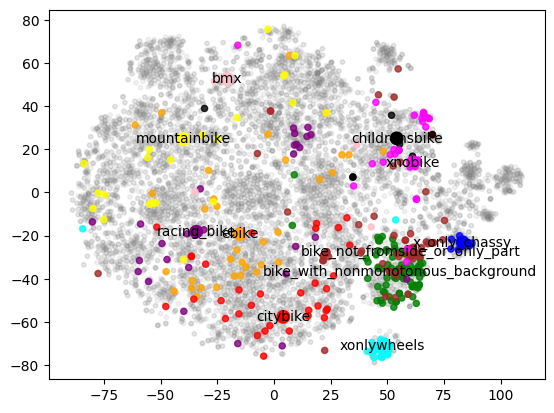

In [22]:
# get some approximate visualization using TSNE
from sklearn.manifold import TSNE


tsne = TSNE(n_components=2)

embeddings_subset_keys = np.random.choice(list(embeddings.keys()), 10000) # use only subset of embeddings to reduce compute time
embeddings_subset = [embeddings[p]['embedding'] for p in embeddings_subset_keys]


labels = [''] * len(embeddings_subset) 
colors = ['grey'] * len(embeddings_subset) 
sizes = [10] * len(embeddings_subset) 
alphas = [0.1] * len(embeddings_subset) 

matplotlib_colors = ['Blue', 'Orange', 'Green', 'Red', 'Purple', 'Brown', 'Pink', 'Black', 'Yellow', 'Cyan', 'Magenta', 'Teal']

class_embeddings = np.array([])
for i,(cls_name, cls) in enumerate(image_classes.items()):
  mean_embedding = [cls['mean_embedding']]
  embd = cls['embeddings']

  if len(class_embeddings) ==0:
    class_embeddings = np.concatenate([mean_embedding,embd])
  else:
    class_embeddings = np.concatenate([class_embeddings,mean_embedding,embd])

  labels += [cls_name] +['']*len(embd)
  colors += [matplotlib_colors[i]] * (1+len(embd))
  sizes += [80]+ [20] * (len(embd))
  alphas += [1]+ [0.8] * (len(embd))



embeddings_subset = np.concatenate([embeddings_subset, class_embeddings])

embeddings_subset = np.array(embeddings_subset)
embeddings_2d = tsne.fit_transform(embeddings_subset)

# plot
print(len(sizes), len(embeddings_2d))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, s=sizes,alpha=alphas)
for i, label in enumerate(labels):
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], label, ha='center', va='center')

With TSNE a high-dimensional space can be reduced to a lower one. This reduced mapping is only useful for visualization, since distances from the high-dimensional space can not be reproduced exactly. Regardless, the visualization shows that the embeddings obtained with the ResNet may be useful in filtering out unwanted images: Some clusters can be observed, for example around "xonlywheels"(cyan), "bike_with_nonmonotonous_background"(dark green) or "x_only_chassy"(blue).  It is observed that "childrens bikes" are similar to "xnobike", mostly "xnobike" are childrens bikes without pedals. The large point corresponds to the mean embedding from each class.

The process is repeated, this time the predictions of the pretrained ResNet classification-head are used to represent the images.

324/324 [==============================] - 2s 4ms/step
10364 10364


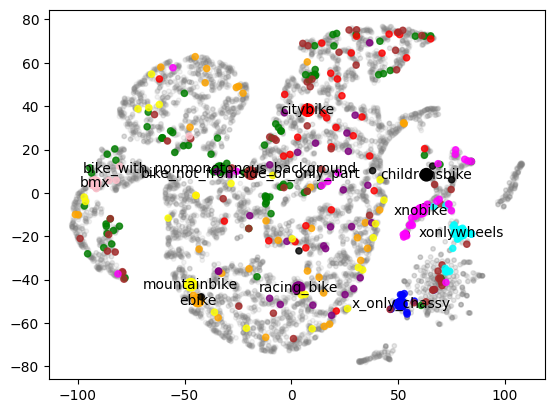

In [23]:
# get some approximate visualization using TSNE, this time with the pretrained classification-head
from sklearn.manifold import TSNE


tsne = TSNE(n_components=2)

embeddings_subset_keys = np.random.choice(list(embeddings.keys()), 10000) # use only subset of embeddings to reduce compute time
embeddings_subset = [embeddings[p]['embedding'] for p in embeddings_subset_keys]


labels = [''] * len(embeddings_subset) 
colors = ['grey'] * len(embeddings_subset) 
sizes = [10] * len(embeddings_subset) 
alphas = [0.1] * len(embeddings_subset) 

matplotlib_colors = ['Blue', 'Orange', 'Green', 'Red', 'Purple', 'Brown', 'Pink', 'Black', 'Yellow', 'Cyan', 'Magenta', 'Teal']

class_embeddings = np.array([])
for i,(cls_name, cls) in enumerate(image_classes.items()):
  mean_embedding = [cls['mean_embedding']]
  embd = cls['embeddings']

  if len(class_embeddings) ==0:
    class_embeddings = np.concatenate([mean_embedding,embd])
  else:
    class_embeddings = np.concatenate([class_embeddings,mean_embedding,embd])

  labels += [cls_name] +['']*len(embd)
  colors += [matplotlib_colors[i]] * (1+len(embd))
  sizes += [80]+ [20] * (len(embd))
  alphas += [1]+ [0.8] * (len(embd))



embeddings_subset = np.concatenate([embeddings_subset, class_embeddings])

embeddings_subset = np.array(embeddings_subset)
embeddings_predictions = model_clf_head.predict(embeddings_subset)
embeddings_2d_clfhead = tsne.fit_transform(embeddings_predictions)

# plot
print(len(sizes), len(embeddings_2d_clfhead))
plt.scatter(embeddings_2d_clfhead[:, 0], embeddings_2d_clfhead[:, 1], c=colors, s=sizes,alpha=alphas)
for i, label in enumerate(labels):
    plt.text(embeddings_2d_clfhead[i, 0], embeddings_2d_clfhead[i, 1], label, ha='center', va='center')

In [24]:
embeddings_1d = TSNE(n_components=1).fit_transform(embeddings_predictions)

This visualization shows the two-dimensional approximation of the ResNets class predictions for the images. These embeddings might be preferable for removing the images from classes "x_only_chassy", "xnobike" and others separated to the right side, since they are separated more clearly. In contrast, as expected, the predictions largely ignore the background and only focus on the object in the image. Therefore "bike_with_nonmonotonous_background" is not "clustered" as in the first visualization, but spread across the space.



In [ ]:
class_embeddings

In [ ]:
'3c206aa6-4f90-3714-b714-3e68b9a5741b_392.99.jpg' in embeddings_lookup._dict.keys()

In [ ]:
type(embeddings_lookup._dict['3c206aa6-4f90-3714-b714-3e68b9a5741b_392.99.jpg'])

## 3. Hyperparameter selection (And reasons for selection): Loss Function, Image Size, Model, Finetuning approach (transfer learning)

## 4. Hyperparameter selection: Optimizer, Learning Rate, Batch Size, Regression Layer depth, (Epochs)

- use bayesian optimization, see https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f

## 5. Layer Activation Visualization

==One Problem was that visualization did not work, because I used a keras model as base model, and my own regression head on top, therefore could not access the base model layers==

maybe some kind of embedding visualization with TSNE / UMAP, e.g. show that classes are close to each other (plot the actual images in 2d plot) -> pretrained model without regression head could be used for classification

## 6. Conclusion